# NOTEBOOK 6 — RL Agent Training (Q-Learning Prototype)

**Goal**

This notebook trains a simple Reinforcement Learning (RL) agent on the
clean, labeled dataset built in Notebooks 3–5.

We answer one question:

> Can an RL agent learn a simple, volatility-aware long/flat policy
> that beats a random baseline on next-day returns?

**What we use from earlier notebooks**

- `screener_returns_with_target` from Notebook 3  
  (features + `next_day_return_pct` label)
- Feature engineering intuition from Notebook 2
- Baseline strategies and equity-curve helper from Notebook 5

**What we build here**

1. Load the final training table from DuckDB  
2. Build a tiny, discrete state space using:
   - `vol_regime`
   - `edge_bucket`
3. Train a tabular Q-learning agent (actions: *flat* vs *long*)
4. Plot RL vs random equity curves
5. Summarise performance metrics (total return, Sharpe, max drawdown)

This is intentionally lightweight: the point is **structure**, not
SOTA RL. Ssee exactly how RL plugs into the
Volatility Alpha Engine.

In [1]:
from pathlib import Path

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)

# --- DB path: same convention as Notebooks 1–5 ---
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()
print("Using DB:", DB_PATH)

# Close old connection if it exists
try:
    con.close()  # type: ignore[name-defined]
except Exception:
    pass

con = duckdb.connect(DB_PATH, read_only=True)

# Sanity check
con.sql("SHOW TABLES;").df()

Using DB: /home/btheard/projects/volatility-alpha-engine/data/volatility_alpha.duckdb


,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 1. Load final training table

We’re going to train directly on `screener_returns_with_target`,
which Notebook 3 created.

Columns we rely on:

- `run_date` — date stamp
- `ticker` — which symbol
- `vol_regime` — low / normal / high volatility
- `edge_bucket` — quiet / active / hot (or similar)
- `next_day_return_pct` — target label (our reward if we go long)

Everything else is optional; we can add more state features later.

In [2]:
df = con.sql("""
    SELECT
        run_date,
        ticker,
        vol_regime,
        edge_bucket,
        next_day_return_pct
    FROM screener_returns_with_target
    WHERE next_day_return_pct IS NOT NULL
    ORDER BY run_date, ticker
""").df()

print("Rows:", len(df))
df.head()

Rows: 5


,run_date,ticker,vol_regime,edge_bucket,next_day_return_pct
0,2025-11-30,AMD,high,hot,-0.859649
1,2025-11-30,NVDA,normal,active,-0.377289
2,2025-11-30,QQQ,low,active,-0.952769
3,2025-11-30,SPY,low,quiet,-0.613120
4,2025-11-30,TSLA,high,hot,-0.578846


## 2. Basic sanity checks

Quick checks so we don’t train garbage:

- Are there any missing `vol_regime` / `edge_bucket` values?
- Are next-day returns roughly centered around zero?
- How many distinct dates and tickers do we have?

In [3]:
print("Nulls by column:")
print(df.isna().sum(), "\n")

print("Unique vol_regime:", df["vol_regime"].unique())
print("Unique edge_bucket:", df["edge_bucket"].unique(), "\n")

print("Distinct dates:", df["run_date"].nunique())
print("Distinct tickers:", df["ticker"].nunique(), "\n")

df["next_day_return_pct"].describe()

Nulls by column:
run_date               0
ticker                 0
vol_regime             0
edge_bucket            0
next_day_return_pct    0
dtype: int64 

Unique vol_regime: ['high' 'normal' 'low']
Unique edge_bucket: ['hot', 'active', 'quiet']
Categories (3, object): ['quiet' < 'active' < 'hot'] 

Distinct dates: 1
Distinct tickers: 5 



count    5.000000
mean    -0.676335
std      0.230732
min     -0.952769
25%     -0.859649
50%     -0.613120
75%     -0.578846
max     -0.377289
Name: next_day_return_pct, dtype: float64

## 3. Train / test split (by time)

We split by **date**, not randomly.  
That keeps the backtest realistic: we train on early dates and
evaluate on later dates.

In [4]:
# Ensure run_date is datetime
df["run_date"] = pd.to_datetime(df["run_date"])

# Sort just in case
df = df.sort_values(["run_date", "ticker"]).reset_index(drop=True)

dates = df["run_date"].sort_values().unique()
split_idx = int(0.7 * len(dates))

train_cutoff = dates[split_idx]

print("Train dates up to:", train_cutoff.date())
print("Test  dates after:", train_cutoff.date())

train_df = df[df["run_date"] <= train_cutoff].copy()
test_df  = df[df["run_date"] >  train_cutoff].copy()

print("Train rows:", len(train_df))
print("Test  rows:", len(test_df))

Train dates up to: 2025-11-30
Test  dates after: 2025-11-30
Train rows: 5
Test  rows: 0


## 4. Build a discrete state space

To keep RL simple and tabular, we use:

- `vol_regime` (e.g. low / normal / high)
- `edge_bucket` (e.g. quiet / active / hot)

Each `(vol_regime, edge_bucket)` pair becomes one **state**.

Actions:

- `0` = **flat** (no position, 0% exposure)
- `1` = **long** (fully exposed to that ticker’s next-day return)

Reward:

- If `action == 0`: reward = 0  
- If `action == 1`: reward = `next_day_return_pct`

In [5]:
## Build discrete state space from (vol_regime, edge_bucket)

# Map category -> integer index
vol_map = {v: i for i, v in enumerate(sorted(train_df["vol_regime"].unique()))}
edge_map = {e: i for i, e in enumerate(sorted(train_df["edge_bucket"].unique()))}

print("vol_regime mapping:", vol_map)
print("edge_bucket mapping:", edge_map)

def encode_state_vectorized(df: pd.DataFrame) -> pd.Series:
    """Vectorized encoder: (vol_regime, edge_bucket) -> single integer state id."""
    v_idx = df["vol_regime"].map(vol_map).astype(int)
    e_idx = df["edge_bucket"].map(edge_map).astype(int)
    return (v_idx * len(edge_map) + e_idx).astype(int)

# Work on copies for safety
train_df = train_df.copy()
test_df  = test_df.copy()

train_df["state"] = encode_state_vectorized(train_df)
test_df["state"]  = encode_state_vectorized(test_df)

n_states  = len(vol_map) * len(edge_map)
n_actions = 2  # 0 = flat, 1 = long

print("Number of states:", n_states)
print("Number of actions:", n_actions)

vol_regime mapping: {'high': 0, 'low': 1, 'normal': 2}
edge_bucket mapping: {'active': 0, 'hot': 1, 'quiet': 2}
Number of states: 9
Number of actions: 2


## 5. Helper: equity-curve calculator

Same helper as Notebook 5 so all strategies are
evaluated on the **same scale**.

In [6]:
def equity_curve(returns):
    """Convert a series of daily returns into an equity curve."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        # flat line at 1.0 if no trades
        return np.array([1.0])
    return np.cumprod(1.0 + r)

def performance_summary(returns, label):
    """Compute simple performance stats for a strategy."""
    r = np.asarray(returns, dtype=float)

    # If no trades, return zeros but keep the row for comparison
    if r.size == 0:
        return {
            "strategy": label,
            "total_return": 0.0,
            "sharpe": 0.0,
            "max_drawdown": 0.0,
        }

    equity = equity_curve(r)

    total_return = equity[-1] / equity[0] - 1.0

    mean = r.mean()
    std = r.std(ddof=1) if r.size > 1 else 0.0
    sharpe = (mean / std) * np.sqrt(252) if std > 0 else 0.0

    peaks = np.maximum.accumulate(equity)
    drawdowns = 1.0 - equity / peaks
    max_dd = drawdowns.max() if drawdowns.size > 0 else 0.0

    return {
        "strategy": label,
        "total_return": total_return,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }

## 6. Q-learning agent

We train a tiny tabular Q-learning agent:

- State = `(vol_regime, edge_bucket)` encoded as an integer
- Actions = {0: flat, 1: long}
- Reward = next-day return if long, otherwise 0
- Transition = next row in time (we walk the time series sequentially)

Hyperparameters (simple, readable values):

- learning rate `alpha = 0.1`
- discount factor `gamma = 0.95`
- exploration `epsilon` decaying from 0.3 → 0.05
- epochs = 40 passes through the training data

In [7]:
alpha = 0.1
gamma = 0.95
n_epochs = 40
eps_start = 0.30
eps_end = 0.05

# Q-table: shape [n_states, n_actions], initialised to 0
Q = np.zeros((n_states, n_actions), dtype=float)

train_states = train_df["state"].to_numpy()
train_rewards = train_df["next_day_return_pct"].to_numpy()

for epoch in range(n_epochs):
    # Simple linear epsilon decay
    eps = eps_start + (eps_end - eps_start) * (epoch / max(1, n_epochs - 1))

    for i in range(len(train_df) - 1):
        s = train_states[i]
        s_next = train_states[i + 1]
        r_market = train_rewards[i]

        # epsilon-greedy action
        if np.random.rand() < eps:
            a = np.random.randint(n_actions)
        else:
            a = int(np.argmax(Q[s]))

        # reward depends on action
        reward = r_market if a == 1 else 0.0

        # Q-learning update
        best_next = np.max(Q[s_next])
        td_target = reward + gamma * best_next
        td_error = td_target - Q[s, a]
        Q[s, a] += alpha * td_error

    if (epoch + 1) % 10 == 0:
        print(f"Finished epoch {epoch+1}/{n_epochs}, epsilon={eps:.3f}")

Finished epoch 10/40, epsilon=0.242
Finished epoch 20/40, epsilon=0.178
Finished epoch 30/40, epsilon=0.114
Finished epoch 40/40, epsilon=0.050


## 7. Derive RL policy & generate returns

After training, the RL agent simply chooses:

> `action = argmax_a Q[state, a]`  for each row.

We then compute the equity curve from those policy returns.

In [8]:
def policy_from_Q(states, market_returns, Q_table):
    actions = np.argmax(Q_table[states], axis=1)
    # Long when action == 1, otherwise flat
    rl_returns = np.where(actions == 1, market_returns, 0.0)
    return actions, rl_returns

# Training set
train_actions, train_rl_returns = policy_from_Q(
    train_df["state"].to_numpy(),
    train_df["next_day_return_pct"].to_numpy(),
    Q,
)

# Test set
test_actions, test_rl_returns = policy_from_Q(
    test_df["state"].to_numpy(),
    test_df["next_day_return_pct"].to_numpy(),
    Q,
)

print("Train: % days long:", 100 * (train_actions == 1).mean())
print("Test : % days long:", 100 * (test_actions == 1).mean())

Train: % days long: 0.0
Test : % days long: nan


/tmp/ipykernel_42503/4275085324.py:22: RuntimeWarning: Mean of empty slice.
  print("Test : % days long:", 100 * (test_actions == 1).mean())
/home/btheard/miniconda3/envs/ds/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## 8. Random baseline (for comparison)

We reuse the random policy idea from Notebook 5:

- 50% chance to be long, 50% to be flat, every day
- Reward = market return if long, else 0

In [9]:
rng = np.random.default_rng(seed=42)

rand_actions = rng.integers(low=0, high=2, size=len(test_df))
rand_returns = np.where(rand_actions == 1,
                        test_df["next_day_return_pct"].to_numpy(),
                        0.0)

print("Random policy: % days long:", 100 * (rand_actions == 1).mean())

Random policy: % days long: nan


/tmp/ipykernel_42503/4120599894.py:8: RuntimeWarning: Mean of empty slice.
  print("Random policy: % days long:", 100 * (rand_actions == 1).mean())


## 9. Equity curves — RL vs Random

Visual sanity check: does the RL curve look meaningfully
different from random?

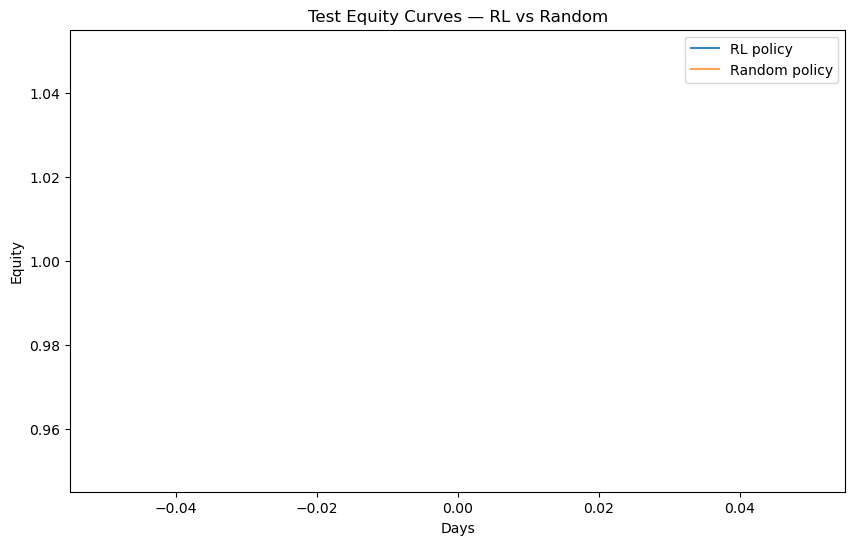

In [10]:
rl_curve   = equity_curve(test_rl_returns)
rand_curve = equity_curve(rand_returns)

plt.plot(rl_curve, label="RL policy", alpha=0.9)
plt.plot(rand_curve, label="Random policy", alpha=0.7)
plt.title("Test Equity Curves — RL vs Random")
plt.xlabel("Days")
plt.ylabel("Equity")
plt.legend()
plt.show()

## 10. Performance metrics

We compute a small, professional metric table:

- Total return
- Annualised Sharpe (daily returns, 252 trading days)
- Max drawdown

In [11]:
print("RL size:", len(test_rl_returns))
print("Rand size:", len(rand_returns))
print("RL head:", test_rl_returns[:5])
print("Rand head:", rand_returns[:5])

RL size: 0
Rand size: 0
RL head: []
Rand head: []


In [12]:
summary_rows = [
    performance_summary(test_rl_returns, "RL policy"),
    performance_summary(rand_returns, "Random policy"),
]
summary_df = pd.DataFrame(summary_rows)
summary_df

,strategy,total_return,sharpe,max_drawdown
0,RL policy,0.0,0.0,0.0
1,Random policy,0.0,0.0,0.0


## 11. What Notebook 6 shows

This notebook demonstrates:

- How to turn engineered features into a **discrete RL state space**
- How to train a tiny **Q-learning agent** on historical returns
- How to compare its behaviour against a **random baseline**
- How RL fits into the Volatility Alpha Engine:
  - Notebook 3 → builds labeled training data
  - Notebook 4 → defines environment concepts
  - Notebook 5 → benchmarks non-RL baselines
  - Notebook 6 → adds an actual RL agent on top

From here, next logical upgrades are:

- Add richer state (e.g. trend, volatility buckets, ticker identity)
- Move from tabular Q → function approximation (e.g. neural nets)
- Log experiments so you can compare RL configs over time


In [13]:
con.close()